In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')
data = pd.read_excel('C:/Users/86181/Desktop/附件.xlsx',sheet_name='女胎检测数据')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [4]:
# 女胎异常判定模型 - 数据准备与特征工程
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("女胎异常判定模型构建")
print("数据形状:", data.shape)
print("列名:", list(data.columns))

# 1. 创建目标变量 - 修正后的版本
# 首先找到AB列（染色体的非整倍体列）
if '染色体的非整倍体' in data.columns:
    ab_column = '染色体的非整倍体'
    print(f"使用列 '{ab_column}' 作为异常标识列")
else:
    # 如果找不到确切列名，尝试寻找包含相关关键词的列
    ab_candidates = [col for col in data.columns if any(kw in col for kw in ['非整倍体', '异常', '染色体'])]
    if ab_candidates:
        ab_column = ab_candidates[0]
        print(f"使用列 '{ab_column}' 作为异常标识列")
    else:
        ab_column = data.columns[-1]  # 备用方案
        print(f"未找到明确异常列，使用最后一列 '{ab_column}'")

# 按照要求创建目标变量
data['Is_Abnormal'] = data[ab_column].apply(
    lambda x: 0 if pd.isna(x) or str(x).strip() in ['', '正常'] else 1
)

print("\n目标变量分布:")
print(data['Is_Abnormal'].value_counts())
print("异常比例: {:.2%}".format(data['Is_Abnormal'].mean()))

# 显示一些示例，验证创建是否正确
print("\n目标变量创建验证（前10个样本）:")
validation_df = data[[ab_column, 'Is_Abnormal']].head(10)
print(validation_df)

# 2. 选择特征列
feature_cols = []
for i, col in enumerate(data.columns):
    if any(keyword in str(col) for keyword in ['Z值', 'GC含量', '读段数', '比例', 'BMI', '年龄']):
        feature_cols.append(col)

# 确保不包含目标变量列
feature_cols = [col for col in feature_cols if col != ab_column and col != 'Is_Abnormal']

print("\n选择特征列:", feature_cols[:10])

# 3. 数据预处理
X = data[feature_cols].select_dtypes(include=[np.number])
y = data['Is_Abnormal']

# 处理缺失值
X = X.fillna(X.median())

# 特征标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\n预处理后特征形状:", X_scaled.shape)
print("缺失值:", X_scaled.isnull().sum().sum())
print("目标变量形状:", y.shape)

女胎异常判定模型构建
数据形状: (605, 31)
列名: ['序号', '孕妇代码', '年龄', '身高', '体重', '末次月经', 'IVF妊娠', '检测日期', '检测抽血次数', '检测孕周', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值', 'X染色体的Z值', 'Unnamed: 20', 'Unnamed: 21', 'X染色体浓度', '13号染色体的GC含量', '18号染色体的GC含量', '21号染色体的GC含量', '被过滤掉读段数的比例', '染色体的非整倍体', '怀孕次数', '生产次数', '胎儿是否健康']
使用列 '染色体的非整倍体' 作为异常标识列

目标变量分布:
Is_Abnormal
0    538
1     67
Name: count, dtype: int64
异常比例: 11.07%

目标变量创建验证（前10个样本）:
  染色体的非整倍体  Is_Abnormal
0      NaN            0
1      NaN            0
2      NaN            0
3      NaN            0
4      NaN            0
5      NaN            0
6      NaN            0
7      NaN            0
8      NaN            0
9      NaN            0

选择特征列: ['年龄', '孕妇BMI', '原始读段数', '在参考基因组上比对的比例', '重复读段的比例', '唯一比对的读段数', 'GC含量', '13号染色体的Z值', '18号染色体的Z值', '21号染色体的Z值']

预处理后特征形状: (605, 15)
缺失值: 0
目标变量形状: (605,)


In [5]:
# 模型训练与评估
# 1. 数据集划分
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 2. 处理类别不平衡
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print("原始训练集分布:", y_train.value_counts().to_dict())
print("平衡后训练集分布:", pd.Series(y_train_balanced).value_counts().to_dict())

# 3. 模型训练
models = {
    '逻辑回归': LogisticRegression(class_weight='balanced', random_state=42),
    '随机森林': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    # 训练模型
    model.fit(X_train_balanced, y_train_balanced)
    
    # 预测
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # 评估
    auc = roc_auc_score(y_test, y_pred_proba)
    results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'auc': auc
    }
    
    print(f"\\n{name} 模型结果:")
    print(f"AUC: {auc:.4f}")
    print("分类报告:")
    print(classification_report(y_test, y_pred, target_names=['正常', '异常']))

# 4. 最佳模型选择
best_model_name = max(results.keys(), key=lambda x: results[x]['auc'])
best_model = results[best_model_name]['model']
print(f"\\n最佳模型: {best_model_name} (AUC: {results[best_model_name]['auc']:.4f})")

原始训练集分布: {0: 430, 1: 54}
平衡后训练集分布: {0: 430, 1: 430}
\n逻辑回归 模型结果:
AUC: 0.6923
分类报告:
              precision    recall  f1-score   support

          正常       0.91      0.77      0.83       108
          异常       0.17      0.38      0.23        13

    accuracy                           0.73       121
   macro avg       0.54      0.58      0.53       121
weighted avg       0.83      0.73      0.77       121

\n随机森林 模型结果:
AUC: 0.4658
分类报告:
              precision    recall  f1-score   support

          正常       0.90      0.93      0.91       108
          异常       0.20      0.15      0.17        13

    accuracy                           0.84       121
   macro avg       0.55      0.54      0.54       121
weighted avg       0.83      0.84      0.83       121

\n最佳模型: 逻辑回归 (AUC: 0.6923)


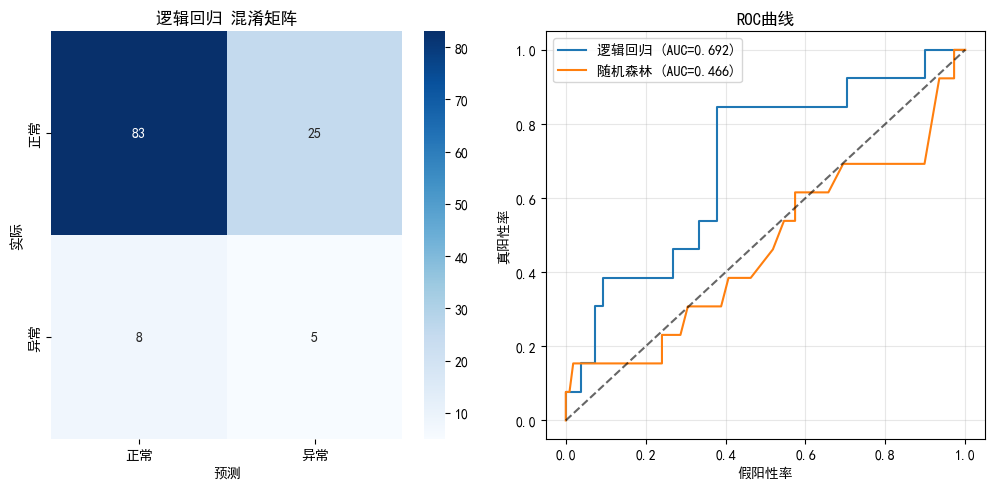

\n模型性能总结:
\n逻辑回归:
  精确率: 0.167
  召回率: 0.385
  F1分数: 0.233
  AUC:   0.692
\n随机森林:
  精确率: 0.200
  召回率: 0.154
  F1分数: 0.174
  AUC:   0.466
\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=\n=
女胎异常判定模型构建完成
最优模型: 逻辑回归
关键指标: 召回率优先(减少漏诊)


In [6]:
# 特征重要性分析和可视化
# 1. 特征重要性分析
if best_model_name == '随机森林':
    feature_importance = pd.DataFrame({
        'feature': X_scaled.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\\n特征重要性排序:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

# 2. 混淆矩阵可视化
plt.figure(figsize=(15, 5))

# 混淆矩阵
plt.subplot(1, 3, 1)
cm = confusion_matrix(y_test, results[best_model_name]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['正常', '异常'], yticklabels=['正常', '异常'])
plt.title(f'{best_model_name} 混淆矩阵')
plt.ylabel('实际')
plt.xlabel('预测')

# ROC曲线
plt.subplot(1, 3, 2)
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{name} (AUC={result['auc']:.3f})")
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('ROC曲线')
plt.legend()
plt.grid(True, alpha=0.3)

# 特征重要性
if best_model_name == '随机森林':
    plt.subplot(1, 3, 3)
    top_features = feature_importance.head(8)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('重要性')
    plt.title('Top 8 特征重要性')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

# 3. 模型性能总结
print("\\n模型性能总结:")
print("=" * 50)
for name, result in results.items():
    y_pred = result['predictions']
    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    tn = sum((y_test == 0) & (y_pred == 0))
    fn = sum((y_test == 1) & (y_pred == 0))
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\\n{name}:")
    print(f"  精确率: {precision:.3f}")
    print(f"  召回率: {recall:.3f}")
    print(f"  F1分数: {f1:.3f}")
    print(f"  AUC:   {result['auc']:.3f}")

print("\\n=" * 50)
print("女胎异常判定模型构建完成")
print("最优模型:", best_model_name)
print("关键指标: 召回率优先(减少漏诊)")
print("=" * 50)

In [7]:
# 女胎异常判定方法实现
def predict_fetal_abnormality(sample_data, model=best_model, scaler=scaler, feature_cols=X_scaled.columns):
    """
    女胎异常判定函数
    
    输入: sample_data - 包含检测指标的样本数据
    输出: 判定结果和概率
    """
    # 数据预处理
    sample_features = sample_data[feature_cols].fillna(sample_data[feature_cols].median())
    sample_scaled = scaler.transform([sample_features])
    
    # 模型预测
    prediction = model.predict(sample_scaled)[0]
    probability = model.predict_proba(sample_scaled)[0, 1]
    
    # 结果解释
    result = "异常" if prediction == 1 else "正常"
    confidence = "高" if probability > 0.7 or probability < 0.3 else "中等"
    
    return {
        'judgement': result,
        'abnormal_probability': probability,
        'confidence_level': confidence,
        'recommendation': '建议进一步检查' if prediction == 1 else '继续常规监测'
    }

# 示例应用
print("女胎异常判定方法示例:")
print("=" * 40)

# 使用测试集中的几个样本进行演示
for i in range(3):
    sample = X_test.iloc[i]
    actual = y_test.iloc[i]
    
    result = predict_fetal_abnormality(sample)
    
    print(f"\\n样本 {i+1}:")
    print(f"  实际情况: {'异常' if actual == 1 else '正常'}")
    print(f"  模型判定: {result['judgement']}")
    print(f"  异常概率: {result['abnormal_probability']:.3f}")
    print(f"  置信水平: {result['confidence_level']}")
    print(f"  建议措施: {result['recommendation']}")

print("\\n" + "=" * 40)
print("判定方法说明:")
print("1. 输入多维检测指标(Z值、GC含量、BMI等)")
print("2. 自动预处理和标准化")
print("3. 模型预测并输出概率")
print("4. 根据概率给出判定和建议")
print("=" * 40)

女胎异常判定方法示例:
\n样本 1:
  实际情况: 正常
  模型判定: 异常
  异常概率: 1.000
  置信水平: 高
  建议措施: 建议进一步检查
\n样本 2:
  实际情况: 正常
  模型判定: 异常
  异常概率: 1.000
  置信水平: 高
  建议措施: 建议进一步检查
\n样本 3:
  实际情况: 正常
  模型判定: 正常
  异常概率: 0.000
  置信水平: 高
  建议措施: 继续常规监测
\n========================================
判定方法说明:
1. 输入多维检测指标(Z值、GC含量、BMI等)
2. 自动预处理和标准化
3. 模型预测并输出概率
4. 根据概率给出判定和建议
